In [3]:
import os
import sys

import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from network_wrangler import RoadwayNetwork

%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("WranglerLogger")
# Set logging.INFO for less info or logging.DEBUG if you want to see everything
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
STPAUL_DIR = os.path.join(os.path.dirname(os.getcwd()),'examples','stpaul')
STPAUL_SHAPE_FILE = os.path.join(STPAUL_DIR, "shape.geojson")
STPAUL_LINK_FILE = os.path.join(STPAUL_DIR, "link.json")
STPAUL_NODE_FILE = os.path.join(STPAUL_DIR, "node.geojson")

In [5]:
net = RoadwayNetwork.read(
    link_file= STPAUL_LINK_FILE, 
    node_file=STPAUL_NODE_FILE, 
    shape_file=STPAUL_SHAPE_FILE, 
    shape_foreign_key ='shape_id',
    fast=True)

2020-11-13 16:14:58, INFO: Reading RoadwayNetwork
2020-11-13 16:15:04, INFO: Read 66253 links from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/examples/stpaul/link.json
2020-11-13 16:15:04, INFO: Read 17159 nodes from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/examples/stpaul/node.geojson
2020-11-13 16:15:04, INFO: Read 66253 shapes from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/examples/stpaul/shape.geojson


# Identify Likely Segment Endpoints

Default settings for `identify_segment_endpoints()` which can be changed with a keyword argument>
 - `mode`: str = "", modal selection
 - `min_connecting_links`: int = 10, Minimum number of connected links
 - `min_distance`: float = None,
 - `max_link_deviation`: int = 2, Number of links a segment can deviate from name or ref consistency

In [6]:
segments_df = net.identify_segment_endpoints(min_connecting_links = 10, max_link_deviation = 2)
segments_df

2020-11-13 16:15:25, WARNING: Assessing connectivity without a mode                specified. This may have limited value in interpretation.                To add mode specificity, add the keyword `mode =` to calling                this method
2020-11-13 16:15:25, WARNING: Following columns not in links_df and wont be added to nodes: [] 


,segment_id,model_node_id,geometry,name,ref
0,0,4785,POINT (-93.07017 44.95271),North Mounds Boulevard,US 61
2,0,4798,POINT (-93.07492 44.95621),North Mounds Boulevard,US 61
8,1,12163,POINT (-93.09827 44.96067),Jackson Street,CR 55
12,1,39484,POINT (-93.09635 44.96475),Jackson Street,CR 55
16,2,36271,POINT (-93.07066 44.92763),Concord Street,MN 156
18,2,50577,POINT (-93.05959 44.91954),Concord Street,MN 156
22,3,45746,POINT (-93.09899 44.97740),Maryland Avenue East,CR 31
24,3,47478,POINT (-93.10148 44.97739),Maryland Avenue East,CR 31
26,4,47478,POINT (-93.10148 44.97739),Maryland Avenue West,CR 31
28,4,311086,POINT (-93.12571 44.97738),Maryland Avenue West,CR 31


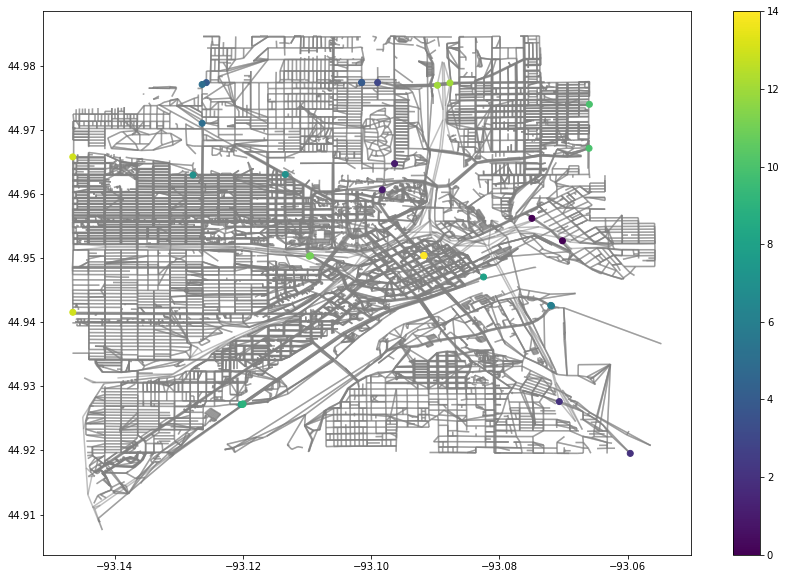

In [7]:
links_p = net.links_df.plot(color="grey",alpha=.5, figsize=(15, 10))
segments_df.plot("segment_id",label="segment_id",ax=links_p,zorder=2,legend=True)

# Find segments

In [8]:
# CREATE SEGMENT SELECTOR

seg_name = segments_df.groupby('segment_id')['name'].agg(lambda x: x.iloc[0]).rename("name")
seg_ref = segments_df.groupby('segment_id')['ref'].agg(lambda x: x.iloc[0]).rename("ref")
seg_selection = pd.concat([seg_name,seg_ref], axis=1)

seg_od = segments_df.groupby('segment_id')['model_node_id'].apply(list).to_dict()

seg_selection["label"]=seg_selection["name"] +" / "+ seg_selection["ref"]
segment_options = list(zip(seg_selection['label'],seg_selection['label'].index))

segment_options = list(zip(seg_selection['label'],seg_selection['label'].index))

segment_selector = widgets.Dropdown(
    options=segment_options,
    description='Number:',
)

In [9]:
@interact(s_id=segment_selector,inbound=True)
def segment_id_to_path_df(s_id, inbound=True):
    sel_seg_df =  segments_df[segments_df['segment_id']==s_id]
    
    if inbound:
        O_id,D_id = sel_seg_df["model_node_id"].to_list()
    else:
        D_id,O_id = sel_seg_df["model_node_id"].to_list()
    
    #only add entry to dict if not empty...
    _names = sel_seg_df["name"].to_list()
    _refs = sel_seg_df["ref"].to_list()
    sel_dict = {}
    if _names:
        sel_dict["name"]= _names[0]
    if _refs:
        sel_dict["ref"]= _refs[0]
    
    seg_df = net.identify_segment(O_id,D_id,selection_dict=sel_dict)
    #print(seg_df)
    #base_links_p = net.links_df.plot(color="grey",alpha=.5, figsize=(15, 10))    
    seg_df.plot("lanes")#,ax=base_links_p,zorder=2)

interactive(children=(Dropdown(description='Number:', options=(('North Mounds Boulevard / US 61', 0), ('Jackso…